In [1]:
import sys
print(sys.executable)
print(sys.version)

/home/aakal/.conda/envs/yolo_flower/bin/python
3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]


In [3]:
import torch
import torchvision
import ultralytics
from ultralytics import YOLO

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("ultralytics:", ultralytics.__version__)
print("cuda:", torch.cuda.is_available())
print("gpu:", torch.cuda.get_device_name(0))

torch: 2.5.1+cu121
torchvision: 0.20.1+cu121
ultralytics: 8.4.11
cuda: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [4]:
import os, glob
print("cwd:", os.getcwd())
print("yolo weights:", glob.glob("yolov5*.pt"))

cwd: /home/aakal
yolo weights: ['yolov5s-cls.pt', 'yolov5su.pt']


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.datasets import Flowers102
from torch.utils.data import ConcatDataset

ROOT = "/home/aakal"
DATA_ROOT = os.path.join(ROOT, "data")
OUT_ROOT = os.path.join(ROOT, "flowers102_yolo_splits")
os.makedirs(OUT_ROOT, exist_ok=True)

# Load raw datasets (PIL images, no transform)
train_raw = Flowers102(root=DATA_ROOT, split="train", download=True, transform=None)
val_raw   = Flowers102(root=DATA_ROOT, split="val",   download=True, transform=None)
test_raw  = Flowers102(root=DATA_ROOT, split="test",  download=True, transform=None)

full_raw = ConcatDataset([train_raw, val_raw, test_raw])

# Labels aligned with ConcatDataset ordering
all_labels = np.concatenate([train_raw._labels, val_raw._labels, test_raw._labels])
all_indices = np.arange(len(full_raw))

def export_split(seed: int, run_name: str):
    run_dir = os.path.join(OUT_ROOT, run_name)
    if os.path.exists(run_dir):
        print("Already exists:", run_dir)
        return run_dir

    # 50% train, 50% temp
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # 25% val, 25% test
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    split_map = {"train": train_idx, "val": val_idx, "test": test_idx}

    for split, idxs in split_map.items():
        for i in idxs:
            img, y = full_raw[i]  # PIL.Image, int label 0..101
            cls = f"{int(y):03d}" # folder names: 000..101
            cls_dir = os.path.join(run_dir, split, cls)
            os.makedirs(cls_dir, exist_ok=True)
            img.save(os.path.join(cls_dir, f"{i}.jpg"), quality=95)

    print("Exported:", run_dir)
    return run_dir

run1_path = export_split(seed=42,   run_name="run1_seed42")
run2_path = export_split(seed=2026, run_name="run2_seed2026")

print("Run1:", run1_path)
print("Run2:", run2_path)


Already exists: /home/aakal/flowers102_yolo_splits/run1_seed42
Already exists: /home/aakal/flowers102_yolo_splits/run2_seed2026
Run1: /home/aakal/flowers102_yolo_splits/run1_seed42
Run2: /home/aakal/flowers102_yolo_splits/run2_seed2026


In [6]:
import os, sys, glob, subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Paths
YOLOV5_DIR = "/home/aakal/yolov5"
WEIGHTS = "/home/aakal/yolov5s-cls.pt"

RUN1_DATA = "/home/aakal/flowers102_yolo_splits/run1_seed42"
RUN2_DATA = "/home/aakal/flowers102_yolo_splits/run2_seed2026"

print("python:", sys.executable)
print("yolov5 dir exists:", os.path.isdir(YOLOV5_DIR))
print("weights exists:", os.path.isfile(WEIGHTS))
print("run1 exists:", os.path.isdir(RUN1_DATA))
print("run2 exists:", os.path.isdir(RUN2_DATA))

python: /home/aakal/.conda/envs/yolo_flower/bin/python
yolov5 dir exists: True
weights exists: True
run1 exists: True
run2 exists: True


In [7]:
import os, sys, glob, subprocess, re
import pandas as pd
import matplotlib.pyplot as plt

def yolo_train(data_dir, epochs=20, batch=64, img=224, device="0", name="flowers_run", exist_ok=True):
    """
    Runs YOLOv5 classification training and returns the run directory path.
    Prints live output to the notebook.
    """
    cmd = [
        sys.executable, "classify/train.py",
        "--model", WEIGHTS,
        "--data", data_dir,
        "--epochs", str(epochs),
        "--batch-size", str(batch),
        "--img", str(img),
        "--device", str(device),
        "--project", "runs/train-cls",
        "--name", name,
    ]
    if exist_ok:
        cmd.append("--exist-ok")

    p = subprocess.Popen(
        cmd,
        cwd=YOLOV5_DIR,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )

    header_pattern = re.compile(r"^\s*(\d+)/(\d+)\s+\S+\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)")

    last_printed_epoch = -1

    for line in p.stdout:
        match = header_pattern.search(line)
        if match:
            curr_ep, tot_ep, train_loss, val_loss, val_acc = match.groups()
            current_epoch_int = int(curr_ep)
            
            if current_epoch_int != last_printed_epoch:
                acc_pct = float(val_acc) * 100
                print(f"Epoch {curr_ep}/{tot_ep} - Loss: {train_loss} - Val Loss: {val_loss} - Val Acc: {acc_pct:.2f}%")
                last_printed_epoch = current_epoch_int

    if p.wait() != 0:
        raise RuntimeError("YOLO training failed (see output above).")

    base = os.path.join(YOLOV5_DIR, "runs", "train-cls")
    run_dir = os.path.join(base, name)
    if not os.path.isfile(os.path.join(run_dir, "results.csv")):
        candidates = sorted(glob.glob(os.path.join(base, f"{name}*")), key=os.path.getmtime)
        if candidates:
            run_dir = candidates[-1]

    return run_dir

In [8]:
def load_yolo_history(run_dir):
    results_csv = os.path.join(run_dir, "results.csv")
    df = pd.read_csv(results_csv)
    df.columns = [c.strip() for c in df.columns]  # remove leading spaces

    needed = ["epoch", "train/loss", "test/loss", "metrics/accuracy_top1", "metrics/accuracy_top5"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print("Available columns:", df.columns.tolist())
        raise RuntimeError(f"Missing columns in results.csv: {missing}")

    hist = pd.DataFrame({
        "epoch": df["epoch"] + 1,
        "train_loss": df["train/loss"],
        "val_loss": df["test/loss"],  # YOLO calls it test, but it is val during training
        "val_acc": df["metrics/accuracy_top1"] * 100,
        "val_top5": df["metrics/accuracy_top5"] * 100,
    })
    return hist

In [9]:
def plot_history(hist, title="Model Training"):
    hist = hist.sort_values(by="epoch")

    plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["val_acc"], marker="o", label="Validation Accuracy", color="#1f77b4")

    plt.title("Validation Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()

    plt.figure(figsize=(10, 6))
    
    plt.plot(hist["epoch"], hist["train_loss"], marker="o", label="Training Loss", color="red")
    
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()

    last = hist.iloc[-1]
    print(f"Final Epoch {int(last['epoch'])}: "
          f"Train Loss={last['train_loss']:.4f}, "
          f"Val Accuracy={last['val_acc']:.2f}%")

In [10]:
def eval_test_accuracy(best_pt, dataset_root, task="test", img=224, batch=64, device="0"):

    temp_root = os.path.join(dataset_root, f"temp_eval_{task}")
    os.makedirs(temp_root, exist_ok=True)

    dummy_val_path = os.path.join(temp_root, "val")
    real_split_path = os.path.join(dataset_root, task)

    if os.path.islink(dummy_val_path) or os.path.exists(dummy_val_path):
        os.remove(dummy_val_path)
        
    os.symlink(real_split_path, dummy_val_path)
    
    try:
        cmd = [
            sys.executable, "classify/val.py",
            "--weights", best_pt,
            "--data", temp_root, 
            "--img", str(img),
            "--batch-size", str(batch),
            "--device", str(device),
        ]

        p = subprocess.Popen(
            cmd,
            cwd=YOLOV5_DIR,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1
        )

        top1 = None
        for line in p.stdout:
            print(line, end="")
            m = re.search(r"\s*all\s+\d+\s+([0-9.]+)", line)
            if m:
                top1 = float(m.group(1)) * 100.0

        if p.wait() != 0:
            raise RuntimeError(f"YOLO {task} evaluation failed.")
            
    finally:
        if os.path.exists(dummy_val_path):
            os.remove(dummy_val_path)
        if os.path.exists(temp_root):
            os.rmdir(temp_root)

    return top1

In [17]:
def plot_comparison(run1_dir, run2_dir):
    hist1 = load_yolo_history(run1_dir).sort_values(by="epoch")
    hist2 = load_yolo_history(run2_dir).sort_values(by="epoch")

    plt.figure(figsize=(10, 5))
    plt.plot(hist1["epoch"], hist1["val_acc"], "b-", linewidth=2, label="Run 1 - Val Acc")
    plt.plot(hist2["epoch"], hist2["val_acc"], "b--", linewidth=2, label="Run 2 - Val Acc")

    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(hist1["epoch"], hist1["train_loss"], "r-", linewidth=2, label="Run 1 - Train Loss")
    plt.plot(hist2["epoch"], hist2["train_loss"], "r--", linewidth=2, label="Run 2 - Train Loss")

    plt.title("Model Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [11]:
dataset_root = "/home/aakal/flowers102_yolo_splits/run1_seed42"
best_pt1 = "/home/aakal/yolov5/runs/train-cls/flowers_run1/weights/best.pt"

==== YOLO Run1 (seed42) ====
Epoch 1/20 - Loss: 2.11 - Val Loss: 1.61 - Val Acc: 78.50%
Epoch 2/20 - Loss: 1.07 - Val Loss: 1.14 - Val Acc: 93.80%
Epoch 3/20 - Loss: 0.914 - Val Loss: 1.11 - Val Acc: 94.20%
Epoch 4/20 - Loss: 0.873 - Val Loss: 1.05 - Val Acc: 95.90%
Epoch 5/20 - Loss: 0.857 - Val Loss: 1.03 - Val Acc: 96.20%
Epoch 6/20 - Loss: 0.845 - Val Loss: 1.03 - Val Acc: 96.60%
Epoch 7/20 - Loss: 0.833 - Val Loss: 1.03 - Val Acc: 97.00%
Epoch 8/20 - Loss: 0.825 - Val Loss: 1.02 - Val Acc: 97.30%
Epoch 9/20 - Loss: 0.821 - Val Loss: 1.01 - Val Acc: 96.80%
Epoch 10/20 - Loss: 0.817 - Val Loss: 1 - Val Acc: 96.90%
Epoch 11/20 - Loss: 0.811 - Val Loss: 1.01 - Val Acc: 97.20%
Epoch 12/20 - Loss: 0.807 - Val Loss: 1.01 - Val Acc: 97.50%
Epoch 13/20 - Loss: 0.804 - Val Loss: 1.01 - Val Acc: 97.00%
Epoch 14/20 - Loss: 0.803 - Val Loss: 1 - Val Acc: 97.50%
Epoch 15/20 - Loss: 0.8 - Val Loss: 1 - Val Acc: 97.60%
Epoch 16/20 - Loss: 0.797 - Val Loss: 1.01 - Val Acc: 97.70%
Epoch 17/20 - Los

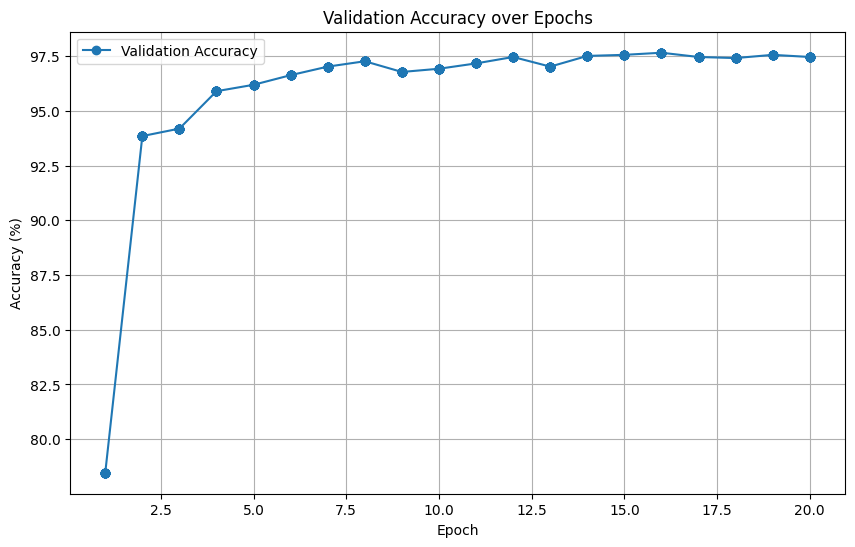

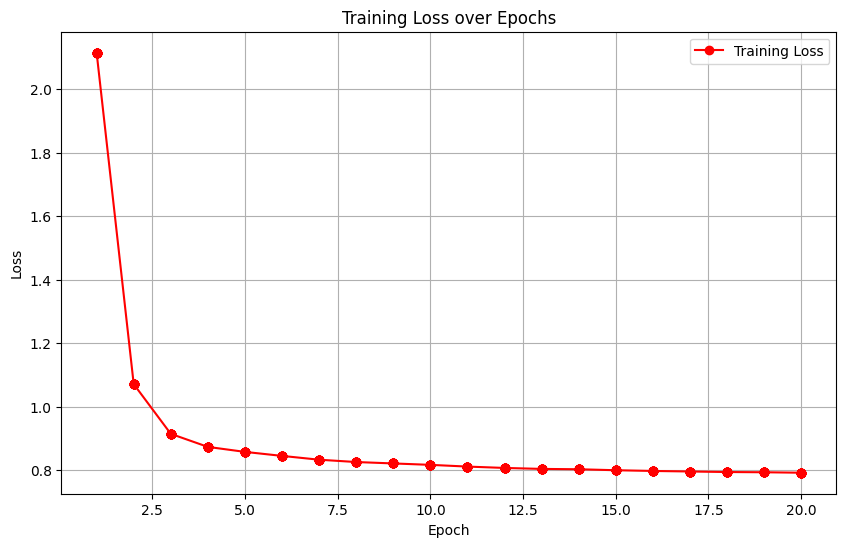

Final Epoch 20: Train Loss=0.7917, Val Accuracy=97.46%
classify/val: data=/home/aakal/flowers102_yolo_splits/run1_seed42/temp_eval_test, weights=['/home/aakal/yolov5/runs/train-cls/flowers_run1/weights/best.pt'], batch_size=64, imgsz=224, device=0, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-459-gdd2e2574 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs

validating:   0%|          | 0/32 [00:00<?, ?it/s]/home/aakal/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):

validating: 100%|██████████| 32/32 [00:02<00:00, 11.50it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2048       0.977       0.997

In [12]:
print("==== YOLO Run1 (seed42) ====")
run1_dir = yolo_train(run1_path, epochs=20, batch=64, img=224, device="0", name="flowers_run1", exist_ok=True)
print("Run1 dir:", run1_dir)

hist1 = load_yolo_history(run1_dir)
plot_history(hist1, title="Validation Accuracy over Epochs - YOLOv5-CLS Run1")

best_pt1 = os.path.join(run1_dir, "weights", "best.pt")
test_acc1 = eval_test_accuracy(best_pt1, run1_path, task="test", img=224, batch=64, device="0")
print("Run1 Test Top-1 Accuracy (%):", test_acc1)

==== YOLO Run2 (seed2026) ====
Epoch 1/20 - Loss: 2.14 - Val Loss: 1.42 - Val Acc: 84.30%
Epoch 2/20 - Loss: 1.07 - Val Loss: 1.15 - Val Acc: 93.00%
Epoch 3/20 - Loss: 0.926 - Val Loss: 1.07 - Val Acc: 95.20%
Epoch 4/20 - Loss: 0.873 - Val Loss: 1.06 - Val Acc: 96.30%
Epoch 5/20 - Loss: 0.858 - Val Loss: 1.03 - Val Acc: 96.50%
Epoch 6/20 - Loss: 0.843 - Val Loss: 1.03 - Val Acc: 96.50%
Epoch 7/20 - Loss: 0.837 - Val Loss: 1.02 - Val Acc: 96.90%
Epoch 8/20 - Loss: 0.828 - Val Loss: 1.02 - Val Acc: 97.40%
Epoch 9/20 - Loss: 0.821 - Val Loss: 1.02 - Val Acc: 96.80%
Epoch 10/20 - Loss: 0.819 - Val Loss: 1 - Val Acc: 97.30%
Epoch 11/20 - Loss: 0.813 - Val Loss: 1.01 - Val Acc: 97.20%
Epoch 12/20 - Loss: 0.808 - Val Loss: 0.999 - Val Acc: 97.30%
Epoch 13/20 - Loss: 0.805 - Val Loss: 1 - Val Acc: 97.50%
Epoch 14/20 - Loss: 0.802 - Val Loss: 1 - Val Acc: 97.70%
Epoch 15/20 - Loss: 0.8 - Val Loss: 1 - Val Acc: 97.70%
Epoch 16/20 - Loss: 0.798 - Val Loss: 1 - Val Acc: 97.70%
Epoch 17/20 - Loss: 

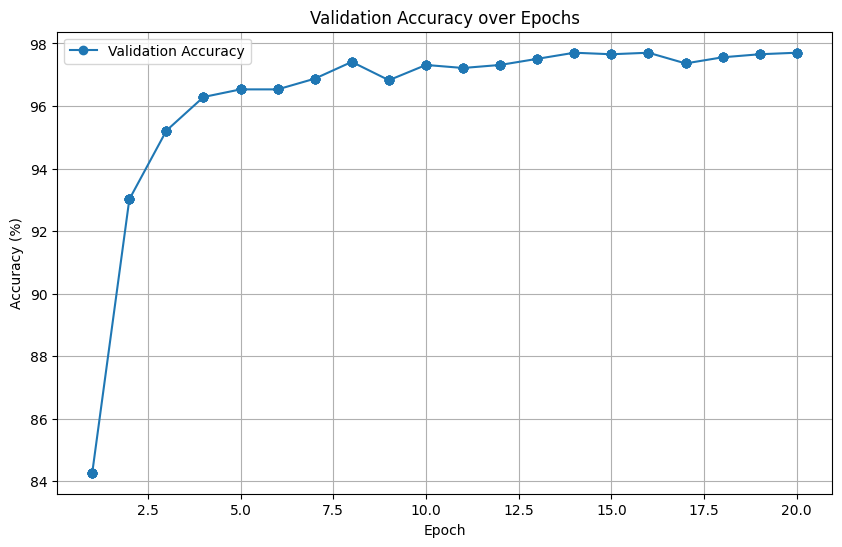

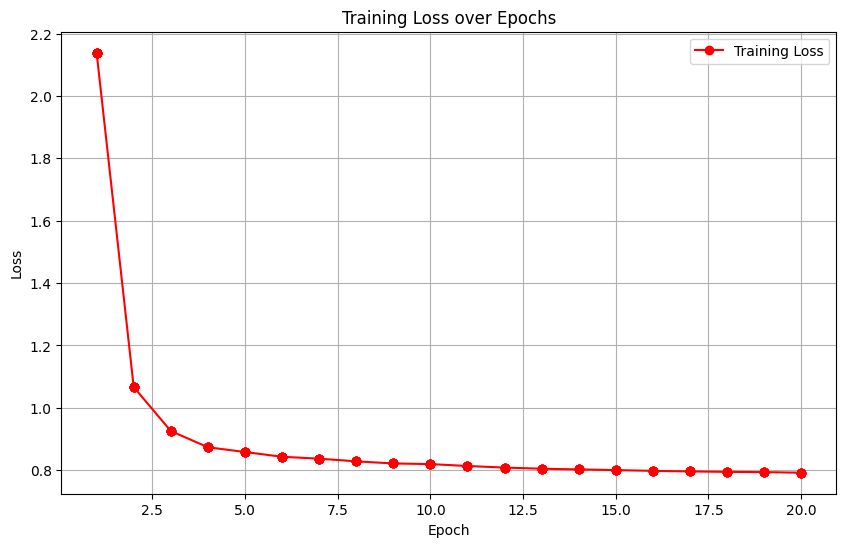

Final Epoch 20: Train Loss=0.7917, Val Accuracy=97.70%
classify/val: data=/home/aakal/flowers102_yolo_splits/run2_seed2026/temp_eval_test, weights=['/home/aakal/yolov5/runs/train-cls/flowers_run1/weights/best.pt'], batch_size=64, imgsz=224, device=0, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-459-gdd2e2574 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs

validating:   0%|          | 0/32 [00:00<?, ?it/s]/home/aakal/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):

validating: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2048       0.985          

In [13]:
print("==== YOLO Run2 (seed2026) ====")
run2_dir = yolo_train(run2_path, epochs=20, batch=64, img=224, device="0", name="flowers_run2", exist_ok=True)
print("Run2 dir:", run2_dir)

hist2 = load_yolo_history(run2_dir)
plot_history(hist2, title="Validation Accuracy over Epochs - YOLOv5-CLS Run2")

best_pt2 = os.path.join(run1_dir, "weights", "best.pt")
test_acc2 = eval_test_accuracy(best_pt2, run2_path, task="test", img=224, batch=64, device="0")
print("Run2 Test Top-1 Accuracy (%):", test_acc2)

In [15]:
summary = pd.DataFrame([
    {"run": "Run 1",   "val_top1_last(%)": float(hist1["val_acc"].iloc[-1]), "test_top1(%)": test_acc1},
    {"run": "Run 2", "val_top1_last(%)": float(hist2["val_acc"].iloc[-1]), "test_top1(%)": test_acc2},
])

summary

,run,val_top1_last(%),test_top1(%)
0,Run 1,97.461,97.7
1,Run 2,97.705,98.5


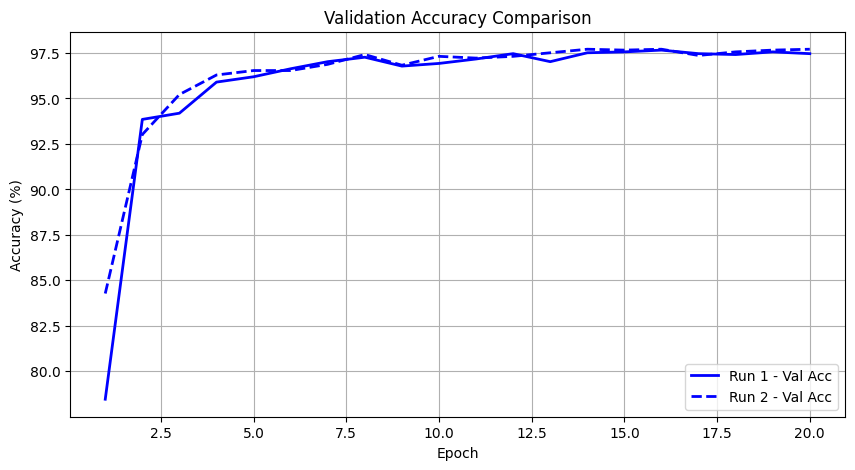

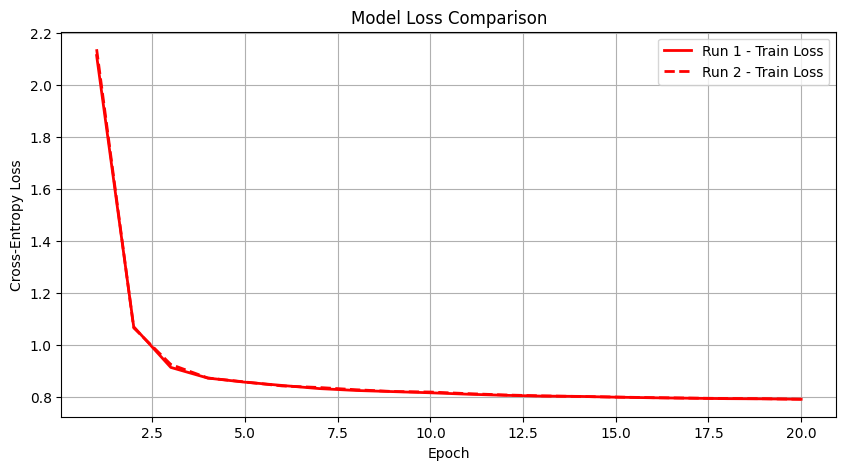

In [18]:
plot_comparison(run1_dir, run2_dir)